In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis

# EMBEDDINGs:
import umap

In [29]:
from import_subset_datasets import *
from clustering_accuracy import acc

In [3]:
def lda_grid(em, mapper):
    AA, BB = np.meshgrid(np.linspace(em.A.min(), em.A.max(), 50),
                     np.linspace(em.B.min(), em.B.max(), 50))
    return AA, BB, mapper.inverse_transform(np.c_[AA.ravel(), BB.ravel()])

In [62]:
def plot_contours(gg, lda, AA, BB, grid):
    print(grid.shape)
    cmaps = ['Reds','Greens','Blues','Purples','Oranges']
    cnt = lda.predict_proba(grid)
    fig = gg.draw()
    ax = fig.get_axes()[0]
    for i in range(cnt.shape[1]):
        ax.contour(AA, BB, cnt[:,i].reshape(AA.shape), cmap=cmaps[i])#, [0.5])

In [58]:
def plot_regions(gg, lda, AA, BB, grid):
    colors = ['r','g','b','c','y']
    preds = lda.predict(grid)
    cnt = lda.predict_proba(grid)
    u = np.unique(preds)
    fig = gg.draw()
    ax = fig.get_axes()[0]
    grid_size = 50
    #pix_size = 
    plt.imshow(preds.reshape(grid_size,-1), extent=[AA.min(),AA.max(),BB.max(),BB.min()],cmap='gray')
    return
    for i in range(grid_size):
        for j in range(grid_size):
            ax.scatter(AA[i,j], BB[i,j], marker='s', ms=2, c=colors[np.where(preds[i*grid_size+j] == u)[0][0]])

In [7]:
np.random.seed(44)
random.seed(44)

read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

In [53]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [3,6,8,9,4]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [54]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [55]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

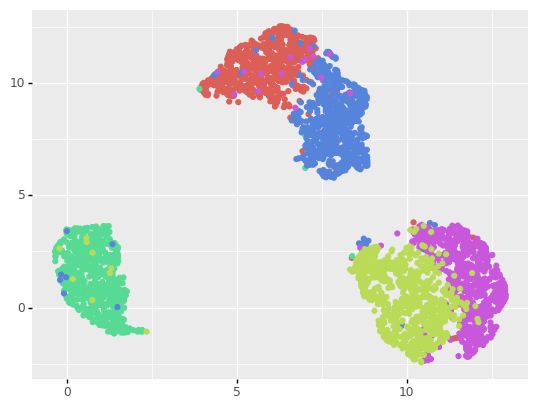

<ggplot: (150169868785)>

In [56]:
gg

In [181]:
nreps = 10

lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)

LinearDiscriminantAnalysis(store_covariance=True)

In [182]:
ret =  lda_grid(em, mapper)

(2500, 30)


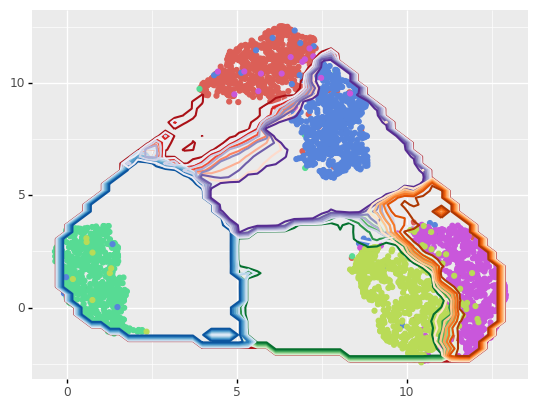

In [183]:
plot_contours(gg, lda, *ret)

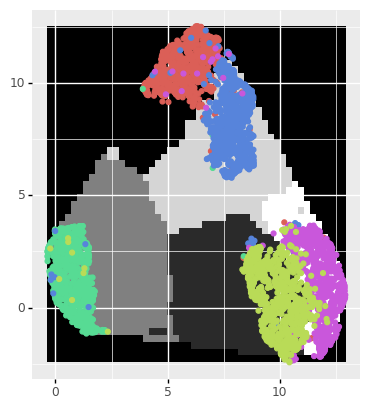

In [184]:
plot_regions(gg, lda, *ret)

In [185]:
print(acc(pd.Series(mnist_test_labels).astype(int), lda.predict(mnist_test_pca).astype(int)))
print(metrics.confusion_matrix(pd.Series(mnist_test_labels).astype(int), lda.predict(mnist_test_pca).astype(int)))

0.9195
[[374   3   3  10  10]
 [  0 366   5   2  27]
 [  2  10 382   6   0]
 [ 17   9   6 353  15]
 [  7  20   4   5 364]]


In [207]:
class LDA():
    def __init__(self):
        self.ks = None #1xK
        self.priors = None #1xK
        self.coefficients = None #KxM
        self.intercepts = None #1xK
        self.means =  None #MxK
        self.covariance = None #MxM
    
    def _discriminants(self, X): #NxM -> KxN
        assert((self.coefficients is not None) and (self.intercepts is not None) and (self.priors is not None))
        return self.coefficients.dot(X.T) + (self.intercepts + np.log(self.priors))[None,:].T
    
    def estimate_mean(self, X): #NxM -> 1xM
        return X.mean(axis=0)
    
    def estimate_covariance(self, X): #NxM -> MxM
        return np.cov(X.T)
    
    def fit(self, X, y):
        self.ks = np.unique(y)
        classes = [X[np.where(y == k), :][0,:,:] for k in self.ks] #Kxn_kxM
        n = np.array([c.shape[0] for c in classes])
        self.means = np.array([self.estimate_mean(c) for c in classes]).T
        self.covariance = np.sum(n[:,None,None] * np.array([self.estimate_covariance(c) for c in classes]), axis=0) / n.sum()
        cov_inv = np.linalg.inv(self.covariance)
        self.coefficients = self.means.T.dot(cov_inv)
        self.intercepts = -0.5*np.diag(self.means.T.dot(cov_inv.dot(self.means)))
        self.priors = n / n.sum()
        
        assert(n.sum() == X.shape[0])
        assert (self.priors.sum() == 1)
    
    def predict(self, X):
        dk = self._discriminants(X)
        return self.ks[dk.argmax(axis=0)] 

In [208]:
test_lda = LDA()

In [209]:
test_lda.fit(mnist_pca, mnist_labels)